# Import libraries

In [22]:
# import libraries
import glob
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Goal

The goal of this project is to explore using convnet to detect cancerous breast cell e.g. invasive ductal carcinoma (IDC). 

# Dataset 

For this project, the Breast Histopathology Images dataset is download from [kaggle](https://www.kaggle.com/paultimothymooney/breast-histopathology-images). As described from the author:

>Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on >the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of >a whole mount slide.
>
>The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted >(198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png . Where u is the patient ID >(10253idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non->IDC and 1 is IDC.


# Consolidate images information into dataframe

For the first step, I will consolidate the image information into a dataframe.

In [2]:
# define image path
IMAGE_PATH = "../data/archive/IDC_regular_ps50_idx5"

In [41]:
information = {
    "patient_id": [],
    "label": [],
    "path": [],
    "file_name": [],
    "img_x": [],
    "img_y": [],
    "height": [],
    "width": [],
}

In [42]:
folders = os.listdir(IMAGE_PATH)
for folder in folders:
    for label in os.listdir(os.path.join(IMAGE_PATH, folder)):
        for image in os.listdir(os.path.join(IMAGE_PATH, folder, label)):
            information["patient_id"] += [folder]
            information["label"] += [label]
            information["path"] += [
                os.path.join(IMAGE_PATH, folder, label, image)
            ]
            information["file_name"] += [image]
            information["img_x"] += [re.search("(?<=_x)\d+", image).group()]
            information["img_y"] += [re.search("(?<=_y)\d+", image).group()]
            information["height"] += [
                cv2.imread(
                    os.path.join(IMAGE_PATH, folder, label, image)
                ).shape[0]
            ]
            information["width"] += [
                cv2.imread(
                    os.path.join(IMAGE_PATH, folder, label, image)
                ).shape[1]
            ]

In [43]:
df = pd.DataFrame(information)

In [58]:
cols = ["patient_id", "label", "img_x", "img_y", "height", "width"]
df[cols] = df[cols].apply(pd.to_numeric)

In [44]:
df.tail()

,patient_id,label,path,file_name,img_x,img_y,height,width
277519,8957,1,../data/archive/IDC_regular_ps50_idx5/8957/1/8...,8957_idx5_x1951_y701_class1.png,1951,701,50,50
277520,8957,1,../data/archive/IDC_regular_ps50_idx5/8957/1/8...,8957_idx5_x2051_y551_class1.png,2051,551,50,50
277521,8957,1,../data/archive/IDC_regular_ps50_idx5/8957/1/8...,8957_idx5_x1951_y651_class1.png,1951,651,50,50
277522,8957,1,../data/archive/IDC_regular_ps50_idx5/8957/1/8...,8957_idx5_x1451_y551_class1.png,1451,551,50,50
277523,8957,1,../data/archive/IDC_regular_ps50_idx5/8957/1/8...,8957_idx5_x1601_y501_class1.png,1601,501,50,50


In [59]:
df.dtypes

patient_id     int64
label          int64
path          object
file_name     object
img_x          int64
img_y          int64
height         int64
width          int64
dtype: object

In [48]:
print("number of images".center(40, "="))
print(len(df))
print("\n")
print("class distribution(raw count)".center(40, "="))
print(df["label"].value_counts())
print("\n")
print("class distribution(percentage)".center(40, "="))
print(df["label"].value_counts(normalize=True))

============number of images============
277524


=====class distribution(raw count)======
0    198738
1     78786
Name: label, dtype: int64


=====class distribution(percentage)=====
0    0.716111
1    0.283889
Name: label, dtype: float64


# EDA

## Random sampling of images

Random images of IDC_+ (malignant) and IDC_-(benign)are plotted.

In [49]:
# define number of samples and random state
n_samples = 10
rand_state = 42

In [50]:
# sample dataframe
sample_images = df.groupby("label", group_keys=False).apply(
    lambda x: x.sample(n_samples, random_state=rand_state)
)

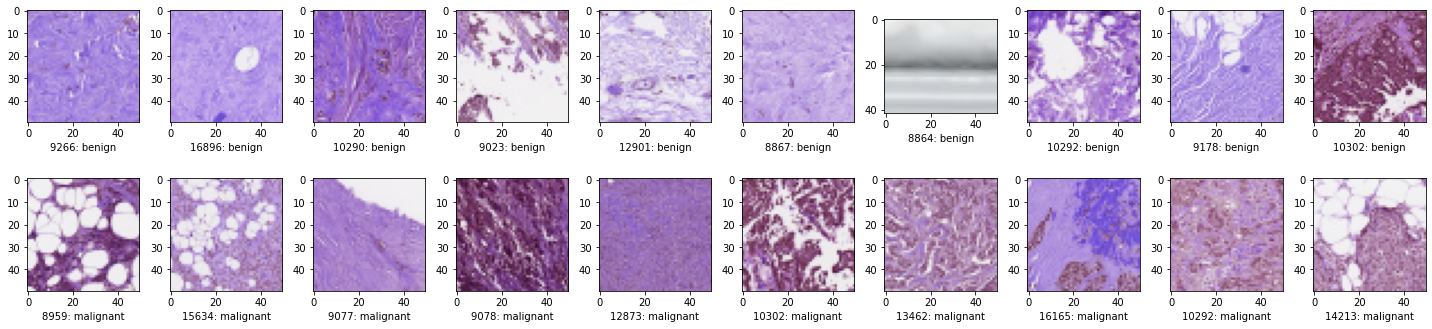

In [51]:
# plot images
plt.figure(figsize=(20, 5))
count = 1
for index, data in sample_images.iterrows():
    plt.subplot(
        2, n_samples, count
    )  # 2 rows for 2 classes, n cols for number of samples
    img = cv2.imread(data["path"])
    plt.imshow(img)
    plt.xlabel(
        f'{data["patient_id"]}: benign'
        if data["label"] == "0"
        else f'{data["patient_id"]}: malignant'
    )
    count += 1
plt.tight_layout()

## Consolidated image from a single patient
In this section, image data from `patient_id` 8957 will be explored further.


In [70]:
patientid = 8957
sub_df = df[df["patient_id"] == patientid]

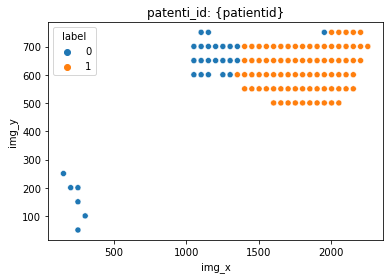

In [71]:
plt.title("patenti_id: {patientid}")
sns.scatterplot(data=sub_df, x="img_x", y="img_y", hue="label");

In [75]:
sub_df["img_x"].max()

2251

## Distribution of the image size
Unfortunately, not all the images are in a square format. Resizing is required. 

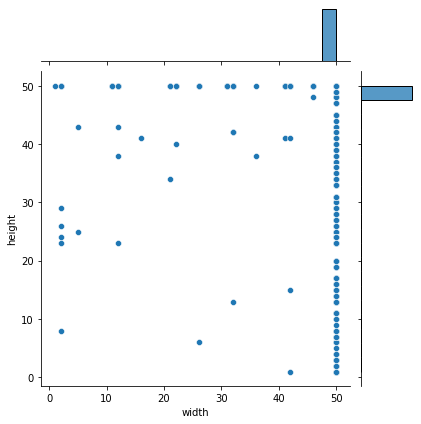

In [15]:
sns.jointplot(x="width", y="height", data=df);

## Distribution of classes

There is a class imbalance as number of IDC(-) images are around 72% while IDC(+) images are 28%.

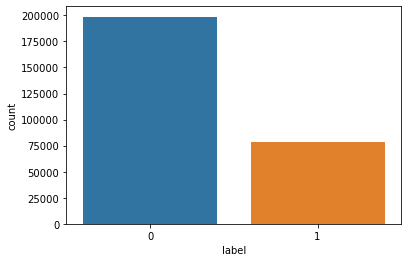

In [47]:
sns.countplot(data=df, x="label");

# Export dataframe

In [77]:
df.to_csv("../data/cancer.csv", index=False)